In [1]:
import logging
from typing import Callable, Literal, Optional, Union

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize

from bwlogger import StyleAdapter
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional, Union, Any

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from aamalha.utils.performance import Performance
from bwbbgdl import GoGet
from bwlogger import StyleAdapter, basic_setup
from bwutils import TODAY, Date

from utils import calculate_weights, get_available_trackers, load_trackers, correlation_to_distance
from plot import plot_results, scatter_plot

c:\Users\pcampos\Anaconda3\envs\bwgi\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
OUTPUT_FOLDER = Path(r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\resultados")
INVERSE_QUOTED = (
    "JPY",
    "HKD",
    "PHP",
    "CHF",
    "CZK",
    "CAD",
    "CLP",
    "DKK",
    "NOK",
    "SEK",
    "RUB",
    "BRL",
    "MXN",
    "HUF",
    "PLN",
    "TRY",
    "ILS",
    "INR",
    "TWD",
    "KRW",
    "IDR",
    "CNH",
    "CNY",
    "SGD",
    "ZAR",
    "THB",
    "COP",
    "MYR",
    "HKD",
)

# Load Data

### Bloomberg Data

In [3]:
path = r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\Projeto Asset Allocation.xlsx"
df_base = pd.read_excel(path, index_col=0, skiprows=1, sheet_name="base_values")
df_base

,IDADDI Index,IDKAP3A Index,BZRFIMB5 Index,BZRFIB5+ Index,BCOMTR Index,IBOV Index,SPXT Index,UKXUSDT Index,HSI 1 Index,NIFTYTR Index,...,BZACCETP Index,G0O1 Index,LT09TRUU Index,B1MSBRUS Index,USDEUR Curncy,USDHKD Curncy,USDINR Curncy,USDCNY Curncy,USDJPY Curncy,USDBRL Curncy
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,139.9930,16930.42,2002.11,NaN,NaN,1688.44,...,5.042832,511.676,165.64,NaN,0.9763,7.7759,43.5300,8.2798,101.45,1.8190
2000-01-04,NaN,NaN,NaN,NaN,139.1780,15851.00,1925.41,NaN,NaN,1737.75,...,5.046277,511.814,166.44,NaN,0.9713,7.7775,43.5050,8.2799,103.22,1.8510
2000-01-05,NaN,NaN,NaN,NaN,138.4490,16245.14,1929.28,NaN,NaN,1692.25,...,5.049719,511.889,165.39,NaN,0.9689,7.7778,43.4900,8.2798,104.14,1.8390
2000-01-06,NaN,NaN,NaN,NaN,138.5270,16106.89,1931.51,NaN,NaN,1715.37,...,5.053163,512.037,165.89,NaN,0.9682,7.7778,43.5400,8.2797,105.23,1.8415
2000-01-07,NaN,NaN,NaN,NaN,138.1060,16309.15,1983.83,NaN,NaN,1710.81,...,5.056610,512.159,166.47,NaN,0.9713,7.7776,43.5500,8.2794,105.34,1.8270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-20,3645.809201,8601.439,9262.328,11124.580,241.9382,120445.91,11931.80,1890.58,61699.92,34873.15,...,81.385160,800.113,463.15,19.3716,0.9344,7.8044,83.6475,7.2604,158.93,5.4501
2024-06-21,3648.057215,8626.378,9275.547,11182.560,239.5644,121341.13,11913.78,1874.10,60667.52,34779.90,...,81.417120,800.472,463.15,19.4079,0.9352,7.8064,83.5400,7.2610,159.80,5.4320
2024-06-24,3649.638713,8646.920,9284.778,11190.810,241.6397,122636.96,11878.04,1893.03,60664.77,34834.33,...,81.449092,800.556,463.61,19.2372,0.9317,7.8079,83.4688,7.2594,159.62,5.3905


### Auxiliar Table

In [4]:
df_base_aux = pd.read_excel(path, index_col=0, usecols="A:F", sheet_name="aux")
df_base_aux

,field,alias,currency,include,excess_index
ticker_bbg,,,,,
IDADDI Index,LAST_PRICE,Debentures,BRL,False,False
IDKAP3A Index,LAST_PRICE,Pre-fixados,BRL,True,False
BZRFIMB5 Index,LAST_PRICE,Inflação (<5),BRL,True,False
BZRFIB5+ Index,LAST_PRICE,Inflação (>5),BRL,True,False
BCOMTR Index,TOT_RETURN_INDEX_GROSS_DVDS,Commodities,USD,True,False
IBOV Index,TOT_RETURN_INDEX_GROSS_DVDS,Ações Brasil,BRL,True,False
SPXT Index,TOT_RETURN_INDEX_GROSS_DVDS,S&P 500,USD,True,False
UKXUSDT Index,TOT_RETURN_INDEX_GROSS_DVDS,FTSE TR Index,USD,True,False
HSI 1 Index,TOT_RETURN_INDEX_GROSS_DVDS,HIS TR Index,HKD,True,False


### Trackers

<Axes: xlabel='Dates'>

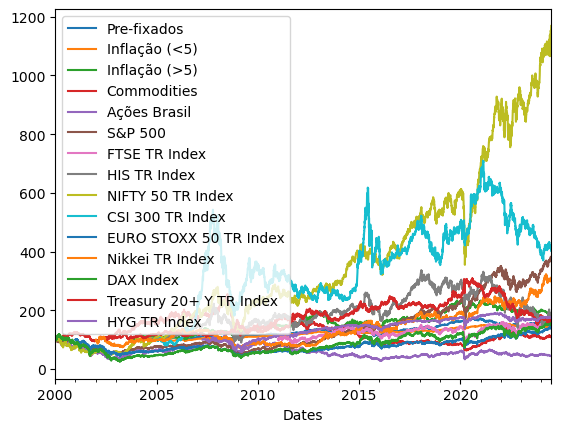

In [5]:
ONSHORE_BENHCMARK = "BZACCETP Index"
OFFSHORE_BENHCMARK = "G0O1 Index"

list_trackers = []
for ticker in df_base_aux[df_base_aux["include"]].index:
    alias = df_base_aux.loc[ticker, "alias"]
    curncy = df_base_aux.loc[ticker, "currency"]
    excess_index = df_base_aux.loc[ticker, "excess_index"]
    s_total_return = df_base[ticker].copy().dropna()

    if curncy == "BRL":
        s_benchmark_return = df_base[ONSHORE_BENHCMARK]
    else: 
        s_benchmark_return = df_base[OFFSHORE_BENHCMARK]
        if curncy != "USD":
            s_total_return_local_ccy = s_total_return
            curncy = "EUR"
            ccy = df_base[f"USD{curncy} Curncy"].copy()
            if curncy in INVERSE_QUOTED:
                ccy = 1 / ccy
            s_total_return_usd = (s_total_return_local_ccy.diff(1) * ccy).dropna()
            s_total_return_usd = s_total_return_usd.reindex(s_total_return_local_ccy.index)
            s_total_return_usd.iloc[0] = (
                s_total_return_local_ccy.iloc[0] * ccy[s_total_return_usd.index[0]]
            )
            s_total_return_usd = s_total_return_usd.cumsum()
            s_total_return = s_total_return_usd.copy()

    if excess_index:
        s_excess_return = s_benchmark_return*0 + 1
    s_excess_return = (s_total_return / s_benchmark_return).dropna()
    s_excess_return.name = alias
    s_excess_return = s_excess_return / s_excess_return.iloc[0] * 100
    list_trackers.append(s_excess_return)

df_trackers = pd.concat(list_trackers, axis=1)

df_trackers.to_excel(OUTPUT_FOLDER.joinpath("trackers_excess_returns.xlsx"))
df_trackers.plot()

## Analysis

### Performance Trackers

In [6]:
perf_trackers = Performance(df_trackers)
df_performance = perf_trackers.table.T.copy()
df_performance.index.name = "Tracker"
df_performance.to_excel(OUTPUT_FOLDER.joinpath("performance_trackers.xlsx"))

### Correlation

In [7]:
df_corr = np.log(df_trackers).diff(1).corr().copy()
df_corr.to_excel(OUTPUT_FOLDER.joinpath("full_sample_correlation.xlsx"))

### Dendogram

C:\Users\pcampos\AppData\Local\Temp\ipykernel_16168\4238899722.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(correlation_to_distance(df_corr), "single", optimal_ordering=True)


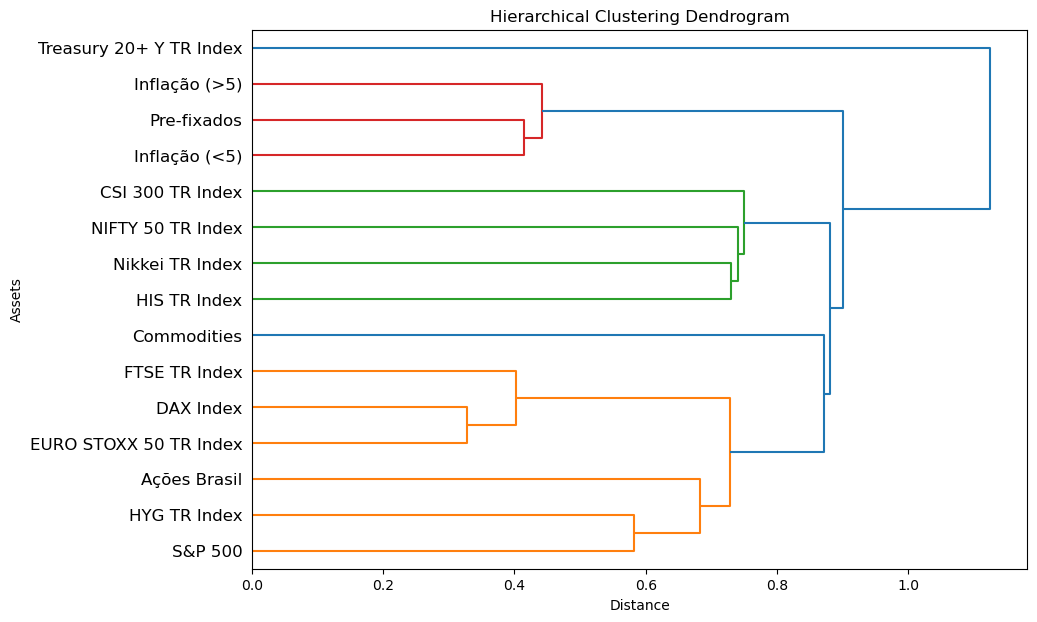

In [8]:
linked = linkage(correlation_to_distance(df_corr), "single", optimal_ordering=True)
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linked,
    orientation="right",
    labels=df_corr.columns,
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Assets")
plt.xlabel("Distance")
plt.savefig(OUTPUT_FOLDER.joinpath("dendrogram.svg"))
plt.show()

## Portfolio Construction

C:\Users\pcampos\AppData\Local\Temp\ipykernel_16168\1765347270.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest = pd.Series(index=tracker_df.index)


<Axes: xlabel='Dates'>

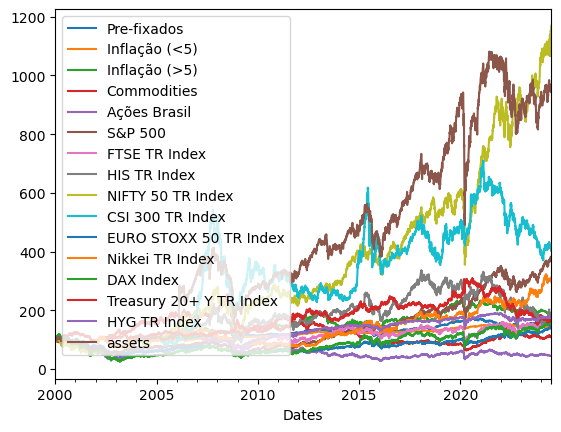

In [9]:
def backtest(
    tracker_df: pd.DataFrame,
    vol_target: float = 0.2,
) -> pd.DataFrame:

    backtest = pd.Series(index=tracker_df.index)
    backtest.iloc[0] = 100.0

    starting_trackers = tracker_df.iloc[0].dropna().index
    cov = np.log(tracker_df)[starting_trackers].diff(21).cov() * 12.0
    vols = pd.Series(index=cov.index, data=np.sqrt(np.diag(cov)))
    w = (1 / vols) / (1 / vols).sum()
    adj_factor = vol_target / np.sqrt(w @ cov @ w)
    w = adj_factor * w

    q = backtest.iloc[0] * w / tracker_df.iloc[0]

    for t, tm1 in zip(backtest.index[1:], backtest.index[:-1]):
        pnl = ((tracker_df.loc[t] - tracker_df.loc[tm1]) * q).sum()
        backtest[t] = backtest[tm1] + pnl
        if t.month != tm1.month:
            if tracker_df.loc[:t].shape[0] > 252:
                available_trackers = tracker_df.loc[t].dropna().index
                cov = np.log(tracker_df.loc[:tm1][available_trackers]).diff(21).cov() * 12.0
                vols = pd.Series(index=cov.index, data=np.sqrt(np.diag(cov)))

            w = (1 / vols) / (1 / vols).sum()
            adj_factor = vol_target / np.sqrt(w @ cov @ w)
            w = adj_factor * w
            q = backtest[tm1] * w / tracker_df.loc[tm1]

    backtest = pd.concat(
        [tracker_df, backtest.to_frame("assets")],
        axis=1,
        join="outer",
        sort=True,
    )

    return backtest

backtest = backtest(df_trackers[df_trackers.columns])
backtest.plot()

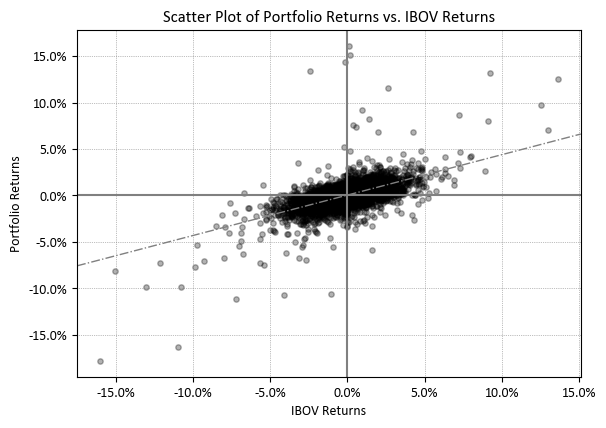

In [10]:
s_portfolio = np.log(backtest["assets"].copy()).diff(1).dropna()
s_ibov = np.log(backtest["Ações Brasil"].copy()).diff(1).dropna()

scatter_plot(
    x_values=s_ibov,
    y_values=s_portfolio,
    yaxis_title="Portfolio Returns",
    xaxis_title="IBOV Returns",
    plot_title="Scatter Plot of Portfolio Returns vs. IBOV Returns",
    fit_type="linear",
)